In [ ]:
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from typing import Tuple
from tqdm import tqdm
import torch

In [ ]:
import random
import numpy as np


def set_seed(seed=50):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
set_seed(50)

In [ ]:
transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

train_ds_full = torchvision.datasets.CIFAR10(
    "cifar_root", transform=transform, download=True
)
test_ds_full = torchvision.datasets.CIFAR10(
    "cifar_root", transform=transform, train=False, download=True
)

100%|██████████| 170M/170M [00:13<00:00, 13.0MB/s]


In [ ]:
TRAIN_SIZE = 5000
TEST_SIZE = 1000

indices = np.random.choice(len(train_ds_full), size=TRAIN_SIZE, replace=False)
train_ds = Subset(train_ds_full, indices)

indices = np.random.choice(len(test_ds_full), size=TEST_SIZE, replace=False)
test_ds = Subset(test_ds_full, indices)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False, pin_memory=True)

In [ ]:
def count_correct(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    preds = torch.argmax(y_pred, dim=1)
    return (preds == y_true).float().sum()


def validate(
    model: nn.Module, loss_fn: torch.nn.CrossEntropyLoss, dataloader: DataLoader
) -> Tuple[torch.Tensor, torch.Tensor]:
    loss = 0
    correct = 0
    all = 0
    for X_batch, y_batch in dataloader:
        y_pred = model(X_batch.cuda())
        all += len(y_pred)
        loss += loss_fn(y_pred, y_batch.cuda()).sum()
        correct += count_correct(y_pred, y_batch.cuda())
    return loss / all, correct / all


def fit(
    model: nn.Module,
    optimiser: optim.Optimizer,
    loss_fn: torch.nn.CrossEntropyLoss,
    train_dl: DataLoader,
    val_dl: DataLoader,
    epochs: int,
    print_metrics: str = True,
):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in tqdm(train_dl):
            y_pred = model(X_batch.cuda())
            loss = loss_fn(y_pred, y_batch.cuda())

            loss.backward()
            optimiser.step()
            optimiser.zero_grad()

        if print_metrics:
            model.eval()
            with torch.no_grad():
                train_loss, train_acc = validate(
                    model=model, loss_fn=loss_fn, dataloader=train_dl
                )
                val_loss, val_acc = validate(
                    model=model, loss_fn=loss_fn, dataloader=val_dl
                )

                train_losses.append(train_loss.item())
                val_losses.append(val_loss.item())
                train_accuracies.append(train_acc.item())
                val_accuracies.append(val_acc.item())

                print(
                    f"Epoch {epoch}: "
                    f"train loss = {train_loss:.3f} (acc: {train_acc:.3f}), "
                    f"validation loss = {val_loss:.3f} (acc: {val_acc:.3f})"
                )

    model.eval()
    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
from matplotlib import pyplot as plt


def compare_on_plots(model_1_scores, model_2_scores):
    fig, ax = plt.subplots(1, 2, figsize=(15, 8))
    epochs = len(model_1_scores["train_loss"])

    color1 = "tab:blue"
    color2 = "tab:orange"
    color3 = "tab:green"

    ax[0].plot(
        range(epochs),
        model_1_scores["train_loss"],
        label=f"{model_1_scores['name']} - Training",
        linestyle="--",
        color=color1,
    )
    ax[0].plot(
        range(epochs),
        model_1_scores["val_loss"],
        label=f"{model_1_scores['name']} - Validation",
        linestyle="-",
        color=color1,
    )
    ax[0].plot(
        range(epochs),
        model_2_scores["train_loss"],
        label=f"{model_2_scores['name']} - Training",
        linestyle="--",
        color=color2,
    )
    ax[0].plot(
        range(epochs),
        model_2_scores["val_loss"],
        label=f"{model_2_scores['name']} - Validation",
        linestyle="-",
        color=color2,
    )
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Value")
    ax[0].set_title("Loss functions comparison")
    ax[0].legend()

    ax[1].plot(
        range(epochs),
        model_1_scores["train_accuracy"],
        label=f"{model_1_scores['name']} - Training",
        linestyle="--",
        color=color1,
    )
    ax[1].plot(
        range(epochs),
        model_1_scores["val_accuracy"],
        label=f"{model_1_scores['name']} - Validation",
        linestyle="-",
        color=color1,
    )
    ax[1].plot(
        range(epochs),
        model_2_scores["train_accuracy"],
        label=f"{model_2_scores['name']} - Training",
        linestyle="--",
        color=color2,
    )
    ax[1].plot(
        range(epochs),
        model_2_scores["val_accuracy"],
        label=f"{model_2_scores['name']} - Validation",
        linestyle="-",
        color=color2,
    )
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Value")
    ax[1].set_title("Accuracies comparison")
    ax[1].legend()

    plt.show()

In [ ]:
import umap
import seaborn as sns
from sklearn.preprocessing import StandardScaler


def get_simclr_representations(simclr_encoder, features_tensor, device="cuda"):
    simclr_encoder.eval()
    with torch.no_grad():
        features_tensor = features_tensor.to(device)
        encoded = simclr_encoder(features_tensor)
        return encoded.cpu().numpy()


def plot_umap(features, labels, title="UMAP of SimCLR Representations"):
    scaled_features = StandardScaler().fit_transform(features)

    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="euclidean")
    embedding = reducer.fit_transform(scaled_features)

    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x=embedding[:, 0],
        y=embedding[:, 1],
        hue=labels,
        palette="tab10",
        s=20,
        alpha=0.7,
    )
    plt.title(title)
    plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()

In [ ]:
from torchvision.models import resnet18

resnet = resnet18(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 55.6MB/s]


# Trening modelu baseline

In [ ]:
resnet = resnet18(pretrained=True)
resnet = resnet.cuda()
loss_fn = nn.CrossEntropyLoss()

optimiser = optim.Adam(resnet.parameters(), lr=1e-4)
resnet_results = fit(
    resnet, optimiser, loss_fn, train_dl, test_dl, epochs=20, print_metrics=True
)

100%|██████████| 157/157 [00:17<00:00,  8.80it/s]


Epoch 0: train loss = 0.007 (acc: 0.938), validation loss = 0.021 (acc: 0.828)


100%|██████████| 157/157 [00:16<00:00,  9.47it/s]


Epoch 1: train loss = 0.001 (acc: 0.992), validation loss = 0.018 (acc: 0.841)


100%|██████████| 157/157 [00:16<00:00,  9.29it/s]


Epoch 2: train loss = 0.000 (acc: 0.998), validation loss = 0.017 (acc: 0.866)


100%|██████████| 157/157 [00:17<00:00,  8.91it/s]


Epoch 3: train loss = 0.000 (acc: 0.998), validation loss = 0.021 (acc: 0.858)


100%|██████████| 157/157 [00:17<00:00,  8.81it/s]


Epoch 4: train loss = 0.000 (acc: 1.000), validation loss = 0.018 (acc: 0.872)


100%|██████████| 157/157 [00:17<00:00,  8.73it/s]


Epoch 5: train loss = 0.000 (acc: 1.000), validation loss = 0.019 (acc: 0.867)


100%|██████████| 157/157 [00:17<00:00,  8.92it/s]


Epoch 6: train loss = 0.000 (acc: 1.000), validation loss = 0.017 (acc: 0.872)


100%|██████████| 157/157 [00:17<00:00,  8.84it/s]


Epoch 7: train loss = 0.000 (acc: 1.000), validation loss = 0.019 (acc: 0.863)


100%|██████████| 157/157 [00:17<00:00,  8.90it/s]


Epoch 8: train loss = 0.001 (acc: 0.991), validation loss = 0.020 (acc: 0.863)


100%|██████████| 157/157 [00:17<00:00,  8.89it/s]


Epoch 9: train loss = 0.001 (acc: 0.989), validation loss = 0.020 (acc: 0.856)


100%|██████████| 157/157 [00:17<00:00,  8.85it/s]


Epoch 10: train loss = 0.001 (acc: 0.992), validation loss = 0.022 (acc: 0.846)


100%|██████████| 157/157 [00:17<00:00,  8.84it/s]


Epoch 11: train loss = 0.000 (acc: 0.999), validation loss = 0.019 (acc: 0.870)


100%|██████████| 157/157 [00:17<00:00,  8.92it/s]


Epoch 12: train loss = 0.000 (acc: 0.999), validation loss = 0.018 (acc: 0.878)


100%|██████████| 157/157 [00:17<00:00,  8.87it/s]


Epoch 13: train loss = 0.000 (acc: 0.998), validation loss = 0.020 (acc: 0.859)


100%|██████████| 157/157 [00:17<00:00,  8.89it/s]


Epoch 14: train loss = 0.000 (acc: 0.997), validation loss = 0.021 (acc: 0.857)


100%|██████████| 157/157 [00:17<00:00,  8.88it/s]


Epoch 15: train loss = 0.000 (acc: 1.000), validation loss = 0.019 (acc: 0.876)


100%|██████████| 157/157 [00:17<00:00,  8.88it/s]


Epoch 16: train loss = 0.000 (acc: 0.998), validation loss = 0.022 (acc: 0.855)


100%|██████████| 157/157 [00:17<00:00,  8.89it/s]


Epoch 17: train loss = 0.000 (acc: 0.998), validation loss = 0.020 (acc: 0.860)


100%|██████████| 157/157 [00:17<00:00,  8.88it/s]


Epoch 18: train loss = 0.000 (acc: 0.996), validation loss = 0.020 (acc: 0.865)


100%|██████████| 157/157 [00:17<00:00,  8.87it/s]


Epoch 19: train loss = 0.001 (acc: 0.992), validation loss = 0.022 (acc: 0.856)


In [ ]:
base_resnet_scores = {
    "name": "Base Resnet",
    "train_loss": resnet_results[0],
    "val_loss": resnet_results[1],
    "train_accuracy": resnet_results[2],
    "val_accuracy": resnet_results[3],
}

# Modele SimCLR

In [ ]:
import torch
from torch import nn, optim, Tensor
from torch.utils.data import DataLoader
import torch.nn.functional as F
from typing import Tuple


class SmallConvnet(nn.Module):
    def __init__(self, input_shape=(3, 224, 224)):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)

        with torch.no_grad():
            dummy = torch.zeros(1, *input_shape)
            n_features = self._get_conv_output(dummy)

        self.fc1 = nn.Linear(n_features, 120)
        self.fc2 = nn.Linear(120, 84)

    def forward(self, x: Tensor) -> Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

    def _get_conv_output(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        return x.numel()


class MLP(nn.Module):
    def __init__(
        self, input_dim: int, hidden_dim: int, output_dim: int, plain_last: bool = False
    ):
        super().__init__()
        layers = [
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, output_dim),
        ]
        if not plain_last:
            layers += [nn.BatchNorm1d(output_dim), nn.ReLU(inplace=True)]

        self.net = nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        return self.net(x)


class FeatureSpaceAugmentation(nn.Module):
    def __init__(self, noise_std=0.1, dropout_p=0.1):
        super().__init__()
        self.noise_std = noise_std
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, x):
        noise = torch.randn_like(x) * self.noise_std
        x = x + noise
        x = self.dropout(x)
        return x


class SimCLRModelFlat(nn.Module):
    def __init__(self, temp=0.1, input_dim=512 * 7 * 7, projection_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
        )
        self.projector = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, projection_dim),
        )
        self.temp = temp
        self.aug_1 = nn.Identity()
        self.aug_2 = nn.Identity()

    def forward(self, x: Tensor) -> Tuple[Tensor, Tensor]:
        x_i = self.aug_1(x)
        x_j = self.aug_2(x)

        z_i = self.projector(self.encoder(x_i))
        z_j = self.projector(self.encoder(x_j))
        return z_i, z_j

    def forward_repr(self, x: Tensor) -> Tensor:
        return self.encoder(x)

    def info_nce_loss(self, z_i: Tensor, z_j: Tensor) -> Tensor:
        z = torch.cat([z_i, z_j], dim=0)
        z = F.normalize(z, dim=1)
        sim = torch.matmul(z, z.T) / self.temp

        batch_size = z_i.size(0)
        N = 2 * batch_size
        identity_mask = ~torch.eye(N, dtype=torch.bool, device=z.device)

        positive_indices = torch.arange(batch_size, device=z.device)
        positives = torch.cat([positive_indices + batch_size, positive_indices])

        numerator = torch.exp(sim[torch.arange(N), positives])
        denominator = torch.sum(torch.exp(sim) * identity_mask, dim=1)

        return (-torch.log(numerator / denominator)).mean()


class SimCLRModelFlatWithHiddenAug(nn.Module):
    def __init__(self, temp=0.1, input_dim=512 * 7 * 7, projection_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
        )
        self.projector = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, projection_dim),
        )
        self.temp = temp
        self.aug_1 = FeatureSpaceAugmentation(noise_std=0.05, dropout_p=0.05)
        self.aug_2 = FeatureSpaceAugmentation(noise_std=0.05, dropout_p=0.05)

    def forward(self, x: Tensor) -> Tuple[Tensor, Tensor]:
        x_i = self.aug_1(x)
        x_j = self.aug_2(x)

        z_i = self.projector(self.encoder(x_i))
        z_j = self.projector(self.encoder(x_j))
        return z_i, z_j

    def forward_repr(self, x: Tensor) -> Tensor:
        return self.encoder(x)

    def info_nce_loss(self, z_i: Tensor, z_j: Tensor) -> Tensor:
        z = torch.cat([z_i, z_j], dim=0)
        z = F.normalize(z, dim=1)
        sim = torch.matmul(z, z.T) / self.temp

        batch_size = z_i.size(0)
        N = 2 * batch_size
        identity_mask = ~torch.eye(N, dtype=torch.bool, device=z.device)

        positive_indices = torch.arange(batch_size, device=z.device)
        positives = torch.cat([positive_indices + batch_size, positive_indices])

        numerator = torch.exp(sim[torch.arange(N), positives])
        denominator = torch.sum(torch.exp(sim) * identity_mask, dim=1)

        return (-torch.log(numerator / denominator)).mean()


def train_simclr(
    model: SimCLRModel,
    dataloader: DataLoader,
    optimizer: optim.Optimizer,
    epochs=10,
    device="cuda",
):
    model.to(device)
    model.train()
    avg_losses = []

    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (x, _) in enumerate(dataloader):
            x = x.to(device)

            z_i, z_j = model(x)
            loss = model.info_nce_loss(z_i, z_j)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if batch_idx % 10 == 0:
                print(
                    f"[Epoch {epoch + 1}] [Batch {batch_idx}] Loss: {loss.item():.4f}"
                )

        avg_loss = running_loss / len(dataloader)
        avg_losses.append(avg_loss)
        print(f"[Epoch {epoch + 1}] Average Loss: {avg_loss:.4f}")

    return avg_losses

# Bazowy trening SimCLR na reprezentacjach z Resneta

In [ ]:
resnet = torchvision.models.resnet18(pretrained=True)
feature_extractor = nn.Sequential(*list(resnet.children())[:-2])

feature_extractor.eval()
all_features = []
all_labels = []

with torch.no_grad():
    for imgs, labels in train_dl:
        feats = feature_extractor(imgs)
        feats = torch.flatten(feats, start_dim=1)
        all_features.append(feats)
        all_labels.append(labels)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
all_features = torch.cat(all_features)
all_labels = torch.cat(all_labels)

In [ ]:
class FeatureDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.labels[idx]
        return x, y

In [ ]:
simclr_train_ds = FeatureDataset(all_features, all_labels)
simclr_train_loader = torch.utils.data.DataLoader(
    simclr_train_ds, batch_size=64, shuffle=True
)

In [ ]:
model_cifar_10_reps = SimCLRModelFlat(temp=0.1, input_dim=512 * 7 * 7)
optimizer = torch.optim.Adam(
    model_cifar_10_reps.parameters(), lr=1e-4, weight_decay=5e-5
)
avg_losses = train_simclr(
    model_cifar_10_reps, simclr_train_loader, optimizer, epochs=30
)

[Epoch 1] [Batch 0] Loss: 3.0782
[Epoch 1] [Batch 10] Loss: 0.5852
[Epoch 1] [Batch 20] Loss: 0.2041
[Epoch 1] [Batch 30] Loss: 0.1394
[Epoch 1] [Batch 40] Loss: 0.1155
[Epoch 1] [Batch 50] Loss: 0.0633
[Epoch 1] [Batch 60] Loss: 0.0688
[Epoch 1] [Batch 70] Loss: 0.0809
[Epoch 1] Average Loss: 0.3451
[Epoch 2] [Batch 0] Loss: 0.0516
[Epoch 2] [Batch 10] Loss: 0.0520
[Epoch 2] [Batch 20] Loss: 0.0469
[Epoch 2] [Batch 30] Loss: 0.0387
[Epoch 2] [Batch 40] Loss: 0.0317
[Epoch 2] [Batch 50] Loss: 0.0332
[Epoch 2] [Batch 60] Loss: 0.0416
[Epoch 2] [Batch 70] Loss: 0.0314
[Epoch 2] Average Loss: 0.0349
[Epoch 3] [Batch 0] Loss: 0.0264
[Epoch 3] [Batch 10] Loss: 0.0277
[Epoch 3] [Batch 20] Loss: 0.0244
[Epoch 3] [Batch 30] Loss: 0.0270
[Epoch 3] [Batch 40] Loss: 0.0308
[Epoch 3] [Batch 50] Loss: 0.0237
[Epoch 3] [Batch 60] Loss: 0.0283
[Epoch 3] [Batch 70] Loss: 0.0303
[Epoch 3] Average Loss: 0.0264
[Epoch 4] [Batch 0] Loss: 0.0353
[Epoch 4] [Batch 10] Loss: 0.0224
[Epoch 4] [Batch 20] Loss: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


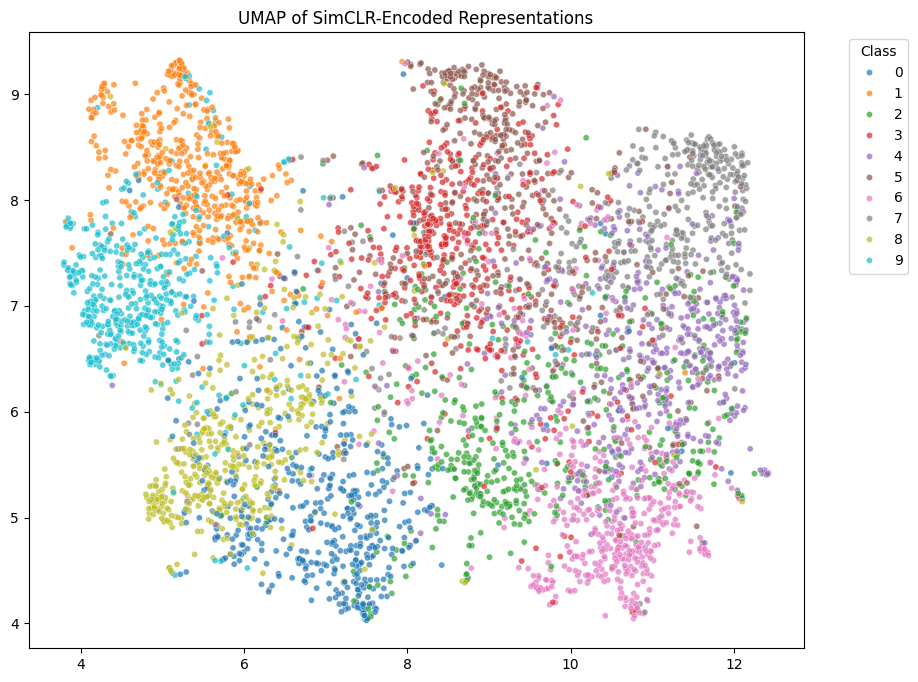

In [ ]:
simclr_features = get_simclr_representations(
    model_cifar_10_reps.encoder, all_features, device=device
)
plot_umap(
    simclr_features, all_labels.numpy(), title="UMAP of SimCLR-Encoded Representations"
)

In [ ]:
class ResNetWithSimCLRPooling(nn.Module):
    def __init__(self, simclr_encoder, projection_dim, output_dim):
        super().__init__()
        resnet = torchvision.models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-2])
        self.simclr_encoder = simclr_encoder
        self.classifier = nn.Linear(projection_dim, output_dim)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.simclr_encoder(x)
        logits = self.classifier(x)
        return logits

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(dataloader, leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / total, correct / total


def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return running_loss / total, correct / total

In [ ]:
def run_experiment(
    simclr_encoder, freeze_simclr=True, epochs=5, lr=1e-4, return_with_metrics=False
):
    projection_dim = simclr_encoder(torch.randn(1, 512 * 7 * 7).to(device)).shape[1]
    model = ResNetWithSimCLRPooling(simclr_encoder, projection_dim, output_dim=10).to(
        device
    )

    if freeze_simclr:
        for param in model.simclr_encoder.parameters():
            param.requires_grad = False

    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        train_loss, train_acc = train_epoch(model, train_dl, optimizer, criterion)
        test_loss, test_acc = evaluate(model, test_dl, criterion)
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Test Loss:  {test_loss:.4f} | Test Acc:  {test_acc:.4f}\n")
        train_losses.append(train_loss)
        val_losses.append(test_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(test_acc)

    if not return_with_metrics:
        return model
    else:
        return model, train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
import copy

simclr_encoder_frozen = copy.deepcopy(model_cifar_10_reps.encoder).to(device).eval()
simclr_encoder_finetune = copy.deepcopy(model_cifar_10_reps.encoder).to(device)

In [ ]:
print("===== Frozen SimCLR Encoder =====")
frozen_model2, train_losses, val_losses, train_accuracies, val_accuracies = (
    run_experiment(
        simclr_encoder_frozen, freeze_simclr=True, epochs=20, return_with_metrics=True
    )
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


===== Frozen SimCLR Encoder =====
Epoch 1/20


Train Loss: 1.1917 | Train Acc: 0.6704
Test Loss:  0.6035 | Test Acc:  0.8390

Epoch 2/20


Train Loss: 0.3729 | Train Acc: 0.9136
Test Loss:  0.5199 | Test Acc:  0.8240

Epoch 3/20


Train Loss: 0.1284 | Train Acc: 0.9788
Test Loss:  0.3815 | Test Acc:  0.8740

Epoch 4/20


Train Loss: 0.0410 | Train Acc: 0.9976
Test Loss:  0.3619 | Test Acc:  0.8760

Epoch 5/20


Train Loss: 0.0172 | Train Acc: 0.9996
Test Loss:  0.3546 | Test Acc:  0.8910

Epoch 6/20


Train Loss: 0.0125 | Train Acc: 0.9992
Test Loss:  0.3646 | Test Acc:  0.8820

Epoch 7/20


Train Loss: 0.0206 | Train Acc: 0.9968
Test Loss:  0.4450 | Test Acc:  0.8540

Epoch 8/20


Train Loss: 0.0806 | Train Acc: 0.9762
Test Loss:  0.4574 | Test Acc:  0.8600

Epoch 9/20


Train Loss: 0.0284 | Train Acc: 0.9924
Test Loss:  0.4350 | Test Acc:  0.8630

Epoch 10/20


Train Loss: 0.0156 | Train Acc: 0.9968
Test Loss:  0.3903 | Test Acc:  0.8780

Epoch 11/20


Train Loss: 0.0149 | Train Acc: 0.9966
Test Loss:  0.3723 | Test Acc:  0.8850

Epoch 12/20


Train Loss: 0.0118 | Train Acc: 0.9972
Test Loss:  0.3864 | Test Acc:  0.8790

Epoch 13/20


Train Loss: 0.0238 | Train Acc: 0.9932
Test Loss:  0.4975 | Test Acc:  0.8680

Epoch 14/20


Train Loss: 0.0362 | Train Acc: 0.9894
Test Loss:  0.4986 | Test Acc:  0.8530

Epoch 15/20


Train Loss: 0.0138 | Train Acc: 0.9960
Test Loss:  0.4541 | Test Acc:  0.8820

Epoch 16/20


Train Loss: 0.0082 | Train Acc: 0.9990
Test Loss:  0.4750 | Test Acc:  0.8820

Epoch 17/20


Train Loss: 0.0038 | Train Acc: 0.9992
Test Loss:  0.4156 | Test Acc:  0.8860

Epoch 18/20


Train Loss: 0.0194 | Train Acc: 0.9954
Test Loss:  0.4812 | Test Acc:  0.8700

Epoch 19/20


Train Loss: 0.0109 | Train Acc: 0.9968
Test Loss:  0.4505 | Test Acc:  0.8770

Epoch 20/20


Train Loss: 0.0106 | Train Acc: 0.9968
Test Loss:  0.4609 | Test Acc:  0.8780



In [ ]:
base_resnet_scores = {
    "name": "Base Resnet",
    "train_loss": resnet_results[0],
    "val_loss": resnet_results[1],
    "train_accuracy": resnet_results[2],
    "val_accuracy": resnet_results[3],
}
frozen_simclr_scores = {
    "name": "Resnet with frozen SimCLR",
    "train_loss": train_losses,
    "val_loss": val_losses,
    "train_accuracy": train_accuracies,
    "val_accuracy": val_accuracies,
}

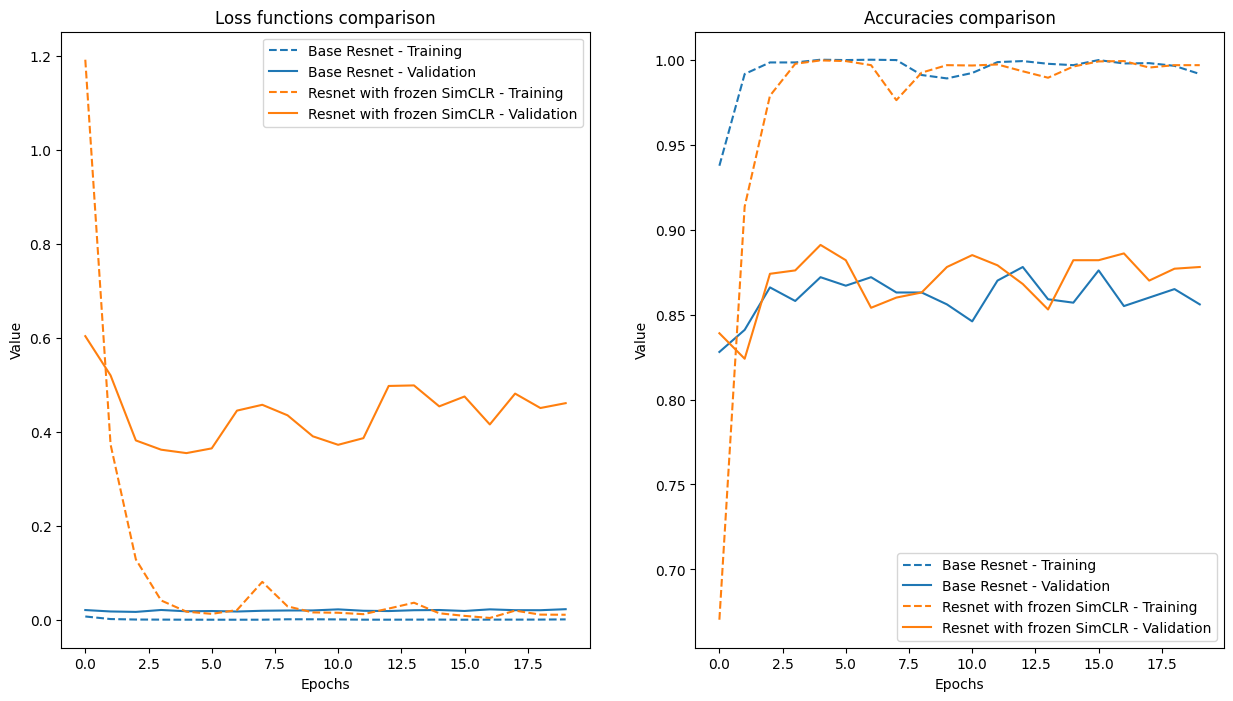

In [ ]:
compare_on_plots(base_resnet_scores, frozen_simclr_scores)

In [ ]:
print("===== Frozen SimCLR Encoder =====")
frozen_model22, train_losses2, val_losses2, train_accuracies2, val_accuracies2 = (
    run_experiment(
        simclr_encoder_frozen, freeze_simclr=True, epochs=20, return_with_metrics=True
    )
)

===== Frozen SimCLR Encoder =====


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20


Train Loss: 1.2210 | Train Acc: 0.6532
Test Loss:  0.6638 | Test Acc:  0.8140

Epoch 2/20


Train Loss: 0.4010 | Train Acc: 0.9034
Test Loss:  0.4544 | Test Acc:  0.8590

Epoch 3/20


Train Loss: 0.1387 | Train Acc: 0.9758
Test Loss:  0.4091 | Test Acc:  0.8640

Epoch 4/20


Train Loss: 0.0464 | Train Acc: 0.9954
Test Loss:  0.3535 | Test Acc:  0.8810

Epoch 5/20


Train Loss: 0.0207 | Train Acc: 0.9994
Test Loss:  0.3636 | Test Acc:  0.8870

Epoch 6/20


Train Loss: 0.0128 | Train Acc: 0.9992
Test Loss:  0.3689 | Test Acc:  0.8930

Epoch 7/20


Train Loss: 0.0168 | Train Acc: 0.9982
Test Loss:  0.4240 | Test Acc:  0.8670

Epoch 8/20


Train Loss: 0.0112 | Train Acc: 0.9992
Test Loss:  0.3893 | Test Acc:  0.8850

Epoch 9/20


Train Loss: 0.0053 | Train Acc: 1.0000
Test Loss:  0.4150 | Test Acc:  0.8760

Epoch 10/20


Train Loss: 0.0518 | Train Acc: 0.9834
Test Loss:  0.6186 | Test Acc:  0.8270

Epoch 11/20


Train Loss: 0.1064 | Train Acc: 0.9684
Test Loss:  0.5088 | Test Acc:  0.8500

Epoch 12/20


Train Loss: 0.0278 | Train Acc: 0.9932
Test Loss:  0.4483 | Test Acc:  0.8690

Epoch 13/20


Train Loss: 0.0099 | Train Acc: 0.9984
Test Loss:  0.3905 | Test Acc:  0.8870

Epoch 14/20


Train Loss: 0.0060 | Train Acc: 0.9994
Test Loss:  0.4139 | Test Acc:  0.8860

Epoch 15/20


Train Loss: 0.0037 | Train Acc: 0.9998
Test Loss:  0.3930 | Test Acc:  0.9000

Epoch 16/20


Train Loss: 0.0029 | Train Acc: 0.9996
Test Loss:  0.4098 | Test Acc:  0.8860

Epoch 17/20


Train Loss: 0.0668 | Train Acc: 0.9774
Test Loss:  0.4981 | Test Acc:  0.8700

Epoch 18/20


Train Loss: 0.0188 | Train Acc: 0.9962
Test Loss:  0.4555 | Test Acc:  0.8760

Epoch 19/20


Train Loss: 0.0101 | Train Acc: 0.9978
Test Loss:  0.4702 | Test Acc:  0.8720

Epoch 20/20


Train Loss: 0.0069 | Train Acc: 0.9984
Test Loss:  0.4523 | Test Acc:  0.8820



In [ ]:
frozen_simclr_scores2 = {
    "name": "Resnet with frozen SimCLR",
    "train_loss": train_losses2,
    "val_loss": val_losses2,
    "train_accuracy": train_accuracies2,
    "val_accuracy": val_accuracies2,
}

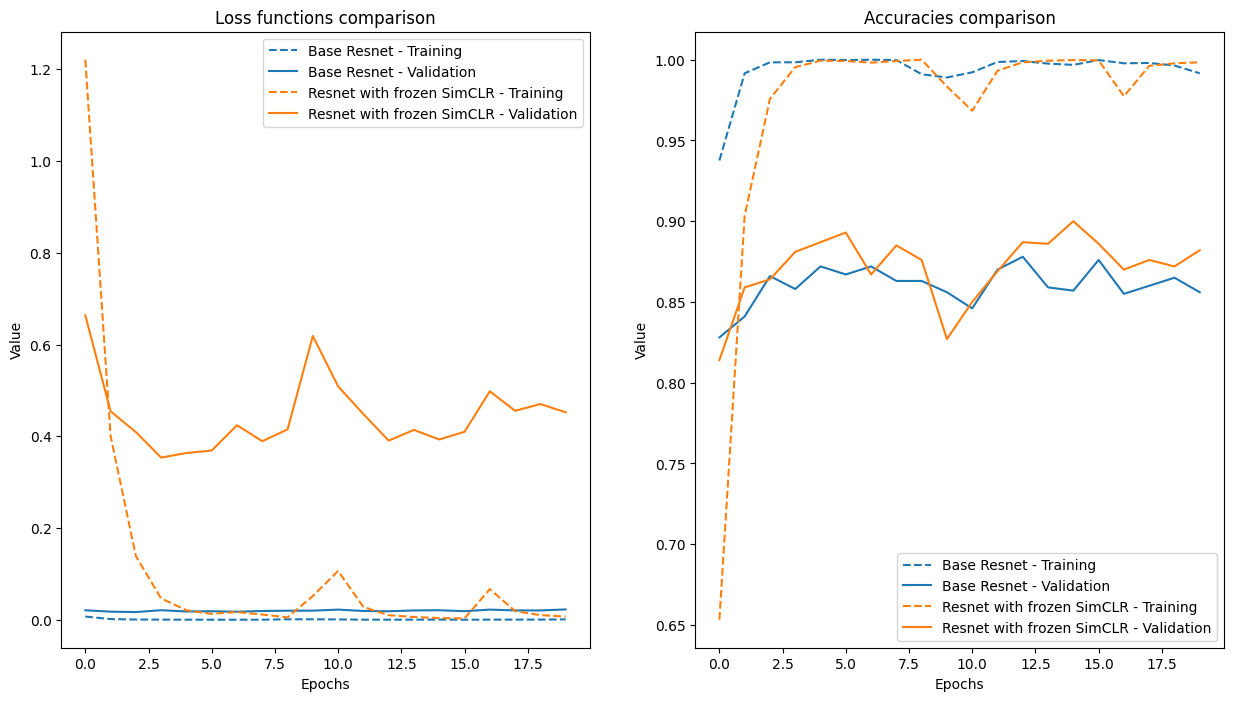

In [ ]:
compare_on_plots(base_resnet_scores, frozen_simclr_scores2)

In [ ]:
print("\n===== Fine-tuned SimCLR Encoder =====")
finetuned_model, train_losses, val_losses, train_accuracies, val_accuracies = (
    run_experiment(
        simclr_encoder_finetune,
        freeze_simclr=False,
        epochs=20,
        return_with_metrics=True,
        lr=5e-5,
    )
)


===== Fine-tuned SimCLR Encoder =====


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20


Train Loss: 0.7703 | Train Acc: 0.7422
Test Loss:  0.4319 | Test Acc:  0.8630

Epoch 2/20


Train Loss: 0.1646 | Train Acc: 0.9480
Test Loss:  0.4254 | Test Acc:  0.8700

Epoch 3/20


Train Loss: 0.0482 | Train Acc: 0.9870
Test Loss:  0.4123 | Test Acc:  0.8880

Epoch 4/20


Train Loss: 0.0177 | Train Acc: 0.9954
Test Loss:  0.4769 | Test Acc:  0.8740

Epoch 5/20


Train Loss: 0.0234 | Train Acc: 0.9922
Test Loss:  0.4374 | Test Acc:  0.8950

Epoch 6/20


Train Loss: 0.0342 | Train Acc: 0.9890
Test Loss:  0.6454 | Test Acc:  0.8590

Epoch 7/20


Train Loss: 0.0337 | Train Acc: 0.9880
Test Loss:  0.5717 | Test Acc:  0.8810

Epoch 8/20


Train Loss: 0.0457 | Train Acc: 0.9844
Test Loss:  0.5799 | Test Acc:  0.8660

Epoch 9/20


Train Loss: 0.0345 | Train Acc: 0.9890
Test Loss:  0.5231 | Test Acc:  0.8680

Epoch 10/20


Train Loss: 0.0299 | Train Acc: 0.9900
Test Loss:  0.5649 | Test Acc:  0.8760

Epoch 11/20


Train Loss: 0.0370 | Train Acc: 0.9888
Test Loss:  0.6599 | Test Acc:  0.8650

Epoch 12/20


Train Loss: 0.0384 | Train Acc: 0.9896
Test Loss:  0.4908 | Test Acc:  0.8910

Epoch 13/20


Train Loss: 0.0191 | Train Acc: 0.9942
Test Loss:  0.6789 | Test Acc:  0.8760

Epoch 14/20


Train Loss: 0.0053 | Train Acc: 0.9988
Test Loss:  0.6135 | Test Acc:  0.8700

Epoch 15/20


Train Loss: 0.0106 | Train Acc: 0.9956
Test Loss:  0.6412 | Test Acc:  0.8740

Epoch 16/20


Train Loss: 0.0098 | Train Acc: 0.9964
Test Loss:  0.6660 | Test Acc:  0.8730

Epoch 17/20


Train Loss: 0.0152 | Train Acc: 0.9956
Test Loss:  0.6497 | Test Acc:  0.8770

Epoch 18/20


Train Loss: 0.0197 | Train Acc: 0.9954
Test Loss:  0.6727 | Test Acc:  0.8710

Epoch 19/20


Train Loss: 0.0284 | Train Acc: 0.9896
Test Loss:  0.7495 | Test Acc:  0.8520

Epoch 20/20


Train Loss: 0.0287 | Train Acc: 0.9918
Test Loss:  0.7524 | Test Acc:  0.8600



In [ ]:
finetuned_simclr_scores = {
    "name": "Resnet with finetuned SimCLR",
    "train_loss": train_losses,
    "val_loss": val_losses,
    "train_accuracy": train_accuracies,
    "val_accuracy": val_accuracies,
}

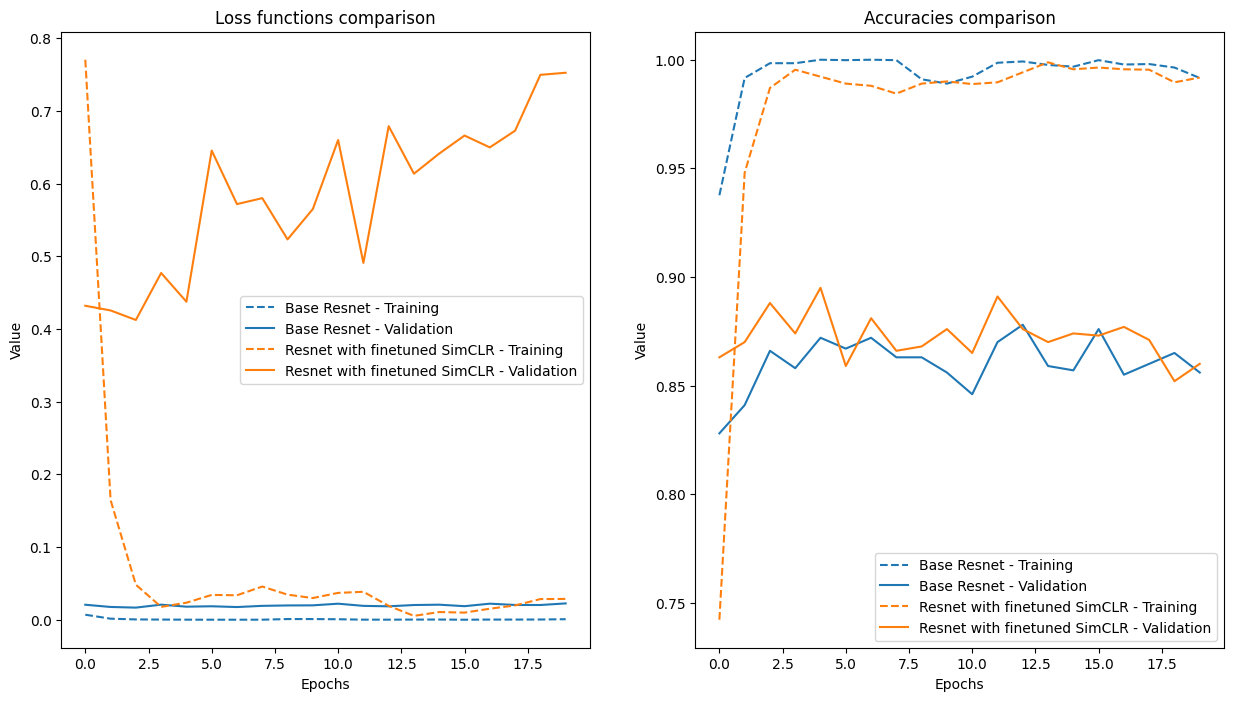

In [ ]:
compare_on_plots(base_resnet_scores, finetuned_simclr_scores)

# Trening z większym rozmiarem batcha

In [ ]:
import numpy as np

TRAIN_SIZE = 5000
TEST_SIZE = 1000

indices = np.random.choice(len(train_ds_full), size=TRAIN_SIZE, replace=False)
train_ds = Subset(train_ds_full, indices)

indices = np.random.choice(len(test_ds_full), size=TEST_SIZE, replace=False)
test_ds = Subset(test_ds_full, indices)

train_dl = DataLoader(train_ds, batch_size=128, shuffle=True, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=128, shuffle=False, pin_memory=True)

In [ ]:
resnet = torchvision.models.resnet18(pretrained=True)
feature_extractor = nn.Sequential(*list(resnet.children())[:-2])

feature_extractor.eval()
all_features = []
all_labels = []

with torch.no_grad():
    for imgs, labels in train_dl:
        feats = feature_extractor(imgs)
        feats = torch.flatten(feats, start_dim=1)
        all_features.append(feats)
        all_labels.append(labels)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
all_features = torch.cat(all_features)
all_labels = torch.cat(all_labels)

In [ ]:
simclr_train_ds = FeatureDataset(all_features, all_labels)
simclr_train_loader = torch.utils.data.DataLoader(
    simclr_train_ds, batch_size=128, shuffle=True
)

In [ ]:
model_cifar_10_reps = SimCLRModelFlat(temp=0.1, input_dim=512 * 7 * 7)
optimizer = torch.optim.Adam(
    model_cifar_10_reps.parameters(), lr=1e-4, weight_decay=1e-4
)
avg_losses = train_simclr(
    model_cifar_10_reps, simclr_train_loader, optimizer, epochs=50
)
avg_losses

[Epoch 1] [Batch 0] Loss: 3.1475
[Epoch 1] [Batch 10] Loss: 0.8910
[Epoch 1] [Batch 20] Loss: 0.3654
[Epoch 1] [Batch 30] Loss: 0.2346
[Epoch 1] Average Loss: 0.8545
[Epoch 2] [Batch 0] Loss: 0.1636
[Epoch 2] [Batch 10] Loss: 0.1315
[Epoch 2] [Batch 20] Loss: 0.1066
[Epoch 2] [Batch 30] Loss: 0.0812
[Epoch 2] Average Loss: 0.1081
[Epoch 3] [Batch 0] Loss: 0.0842
[Epoch 3] [Batch 10] Loss: 0.0726
[Epoch 3] [Batch 20] Loss: 0.0593
[Epoch 3] [Batch 30] Loss: 0.0637
[Epoch 3] Average Loss: 0.0686
[Epoch 4] [Batch 0] Loss: 0.0636
[Epoch 4] [Batch 10] Loss: 0.0565
[Epoch 4] [Batch 20] Loss: 0.0511
[Epoch 4] [Batch 30] Loss: 0.0491
[Epoch 4] Average Loss: 0.0508
[Epoch 5] [Batch 0] Loss: 0.0512
[Epoch 5] [Batch 10] Loss: 0.0495
[Epoch 5] [Batch 20] Loss: 0.0425
[Epoch 5] [Batch 30] Loss: 0.0489
[Epoch 5] Average Loss: 0.0463
[Epoch 6] [Batch 0] Loss: 0.0446
[Epoch 6] [Batch 10] Loss: 0.0465
[Epoch 6] [Batch 20] Loss: 0.0386
[Epoch 6] [Batch 30] Loss: 0.0419
[Epoch 6] Average Loss: 0.0417
[Epo

[0.8544853887986392,
 0.1080501104472205,
 0.06862522107549011,
 0.05084173938375898,
 0.04633878300664947,
 0.04168746516807005,
 0.03779128137393854,
 0.035258795626577924,
 0.03400875906518195,
 0.031777450302615765,
 0.030649919342249633,
 0.0289763170061633,
 0.028448792902054265,
 0.02732706695096567,
 0.027797112439293413,
 0.0268104251998011,
 0.026790636725490913,
 0.026047367230057718,
 0.02502984470629599,
 0.024928090308094397,
 0.02427416124555748,
 0.024774078675545753,
 0.024318893149029464,
 0.024088600004324688,
 0.024262043833732604,
 0.02388321562903002,
 0.02330364532826934,
 0.02334273898159154,
 0.023286403428937775,
 0.02303391796303913,
 0.022570617977180518,
 0.022792145487619563,
 0.023414376319851726,
 0.022568588942522182,
 0.022095135087147354,
 0.022503319449606353,
 0.022410186106571927,
 0.02194709636969492,
 0.022115259006386622,
 0.022037748765433206,
 0.02197428895160556,
 0.021656039741355926,
 0.021456916950410233,
 0.021939242305234075,
 0.02133656

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


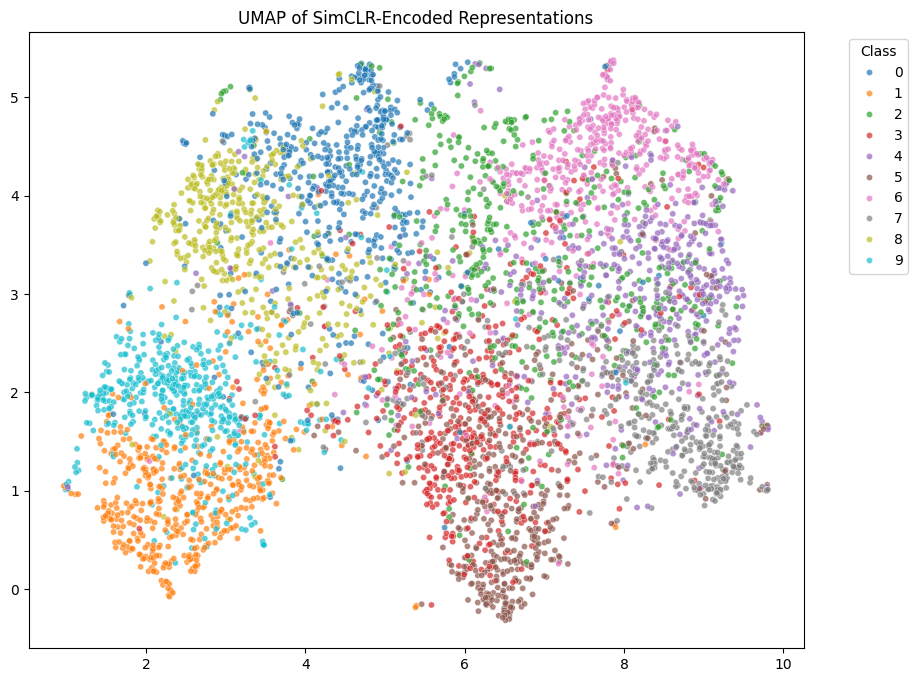

In [ ]:
simclr_features = get_simclr_representations(
    model_cifar_10_reps.encoder, all_features, device=device
)
plot_umap(
    simclr_features, all_labels.numpy(), title="UMAP of SimCLR-Encoded Representations"
)

In [ ]:
import copy

simclr_encoder_frozen = copy.deepcopy(model_cifar_10_reps.encoder).to(device).eval()
simclr_encoder_finetune = copy.deepcopy(model_cifar_10_reps.encoder).to(device)

In [ ]:
print("===== Frozen SimCLR Encoder =====")
frozen_model2, train_losses, val_losses, train_accuracies, val_accuracies = (
    run_experiment(
        simclr_encoder_frozen, freeze_simclr=True, epochs=20, return_with_metrics=True
    )
)

===== Frozen SimCLR Encoder =====


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20


Train Loss: 1.6112 | Train Acc: 0.5382
Test Loss:  1.0236 | Test Acc:  0.7350

Epoch 2/20


Train Loss: 0.7243 | Train Acc: 0.8552
Test Loss:  0.6839 | Test Acc:  0.8250

Epoch 3/20


Train Loss: 0.3587 | Train Acc: 0.9422
Test Loss:  0.5560 | Test Acc:  0.8400

Epoch 4/20


Train Loss: 0.1682 | Train Acc: 0.9842
Test Loss:  0.4798 | Test Acc:  0.8560

Epoch 5/20


Train Loss: 0.0771 | Train Acc: 0.9976
Test Loss:  0.4334 | Test Acc:  0.8620

Epoch 6/20


Train Loss: 0.0504 | Train Acc: 0.9988
Test Loss:  0.4458 | Test Acc:  0.8650

Epoch 7/20


Train Loss: 0.0345 | Train Acc: 0.9990
Test Loss:  0.4381 | Test Acc:  0.8600

Epoch 8/20


Train Loss: 0.0197 | Train Acc: 1.0000
Test Loss:  0.4210 | Test Acc:  0.8710

Epoch 9/20


Train Loss: 0.0158 | Train Acc: 0.9996
Test Loss:  0.4327 | Test Acc:  0.8720

Epoch 10/20


Train Loss: 0.0405 | Train Acc: 0.9966
Test Loss:  0.4368 | Test Acc:  0.8540

Epoch 11/20


Train Loss: 0.0155 | Train Acc: 0.9998
Test Loss:  0.4138 | Test Acc:  0.8720

Epoch 12/20


Train Loss: 0.0160 | Train Acc: 0.9988
Test Loss:  0.4145 | Test Acc:  0.8630

Epoch 13/20


Train Loss: 0.0193 | Train Acc: 0.9976
Test Loss:  0.4507 | Test Acc:  0.8690

Epoch 14/20


Train Loss: 0.0766 | Train Acc: 0.9824
Test Loss:  0.4705 | Test Acc:  0.8630

Epoch 15/20


Train Loss: 0.0183 | Train Acc: 0.9978
Test Loss:  0.4047 | Test Acc:  0.8750

Epoch 16/20


Train Loss: 0.0074 | Train Acc: 1.0000
Test Loss:  0.4116 | Test Acc:  0.8810

Epoch 17/20


Train Loss: 0.0058 | Train Acc: 1.0000
Test Loss:  0.4138 | Test Acc:  0.8810

Epoch 18/20


Train Loss: 0.0050 | Train Acc: 1.0000
Test Loss:  0.4164 | Test Acc:  0.8810

Epoch 19/20


Train Loss: 0.0037 | Train Acc: 1.0000
Test Loss:  0.4057 | Test Acc:  0.8870

Epoch 20/20


Train Loss: 0.0034 | Train Acc: 1.0000
Test Loss:  0.4369 | Test Acc:  0.8750



In [ ]:
larger_batch_frozen_simclr_scores = {
    "name": "Resnet with frozen SimCLR (bigger batch)",
    "train_loss": train_losses,
    "val_loss": val_losses,
    "train_accuracy": train_accuracies,
    "val_accuracy": val_accuracies,
}

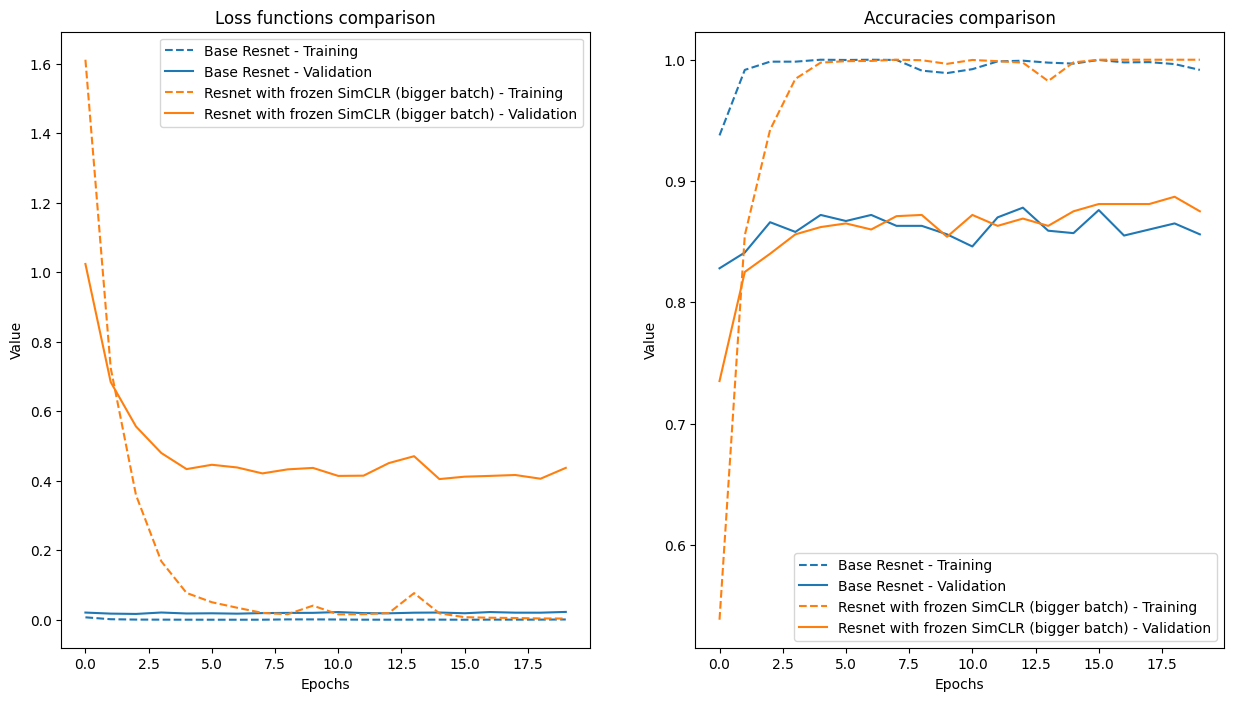

In [ ]:
compare_on_plots(base_resnet_scores, larger_batch_frozen_simclr_scores)

In [ ]:
print("\n===== Fine-tuned SimCLR Encoder =====")
finetuned_model, train_losses, val_losses, train_accuracies, val_accuracies = (
    run_experiment(
        simclr_encoder_frozen, freeze_simclr=False, epochs=20, return_with_metrics=True
    )
)


===== Fine-tuned SimCLR Encoder =====


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20


Train Loss: 0.8602 | Train Acc: 0.7110
Test Loss:  0.4467 | Test Acc:  0.8350

Epoch 2/20


Train Loss: 0.1670 | Train Acc: 0.9452
Test Loss:  0.3912 | Test Acc:  0.8750

Epoch 3/20


Train Loss: 0.0672 | Train Acc: 0.9796
Test Loss:  0.3776 | Test Acc:  0.8750

Epoch 4/20


Train Loss: 0.0387 | Train Acc: 0.9878
Test Loss:  0.4234 | Test Acc:  0.8840

Epoch 5/20


Train Loss: 0.0378 | Train Acc: 0.9884
Test Loss:  0.3946 | Test Acc:  0.8840

Epoch 6/20


Train Loss: 0.0294 | Train Acc: 0.9900
Test Loss:  0.4281 | Test Acc:  0.8870

Epoch 7/20


Train Loss: 0.0136 | Train Acc: 0.9960
Test Loss:  0.4984 | Test Acc:  0.8710

Epoch 8/20


Train Loss: 0.0348 | Train Acc: 0.9898
Test Loss:  0.4216 | Test Acc:  0.8870

Epoch 9/20


Train Loss: 0.0060 | Train Acc: 0.9982
Test Loss:  0.4225 | Test Acc:  0.8890

Epoch 10/20


Train Loss: 0.0139 | Train Acc: 0.9958
Test Loss:  0.4685 | Test Acc:  0.8960

Epoch 11/20


Train Loss: 0.0025 | Train Acc: 0.9996
Test Loss:  0.4516 | Test Acc:  0.8990

Epoch 12/20


Train Loss: 0.0031 | Train Acc: 0.9986
Test Loss:  0.5104 | Test Acc:  0.8780

Epoch 13/20


Train Loss: 0.0678 | Train Acc: 0.9804
Test Loss:  0.7520 | Test Acc:  0.8310

Epoch 14/20


Train Loss: 0.0354 | Train Acc: 0.9874
Test Loss:  0.5452 | Test Acc:  0.8810

Epoch 15/20


Train Loss: 0.0091 | Train Acc: 0.9972
Test Loss:  0.5488 | Test Acc:  0.8850

Epoch 16/20


Train Loss: 0.0044 | Train Acc: 0.9990
Test Loss:  0.5758 | Test Acc:  0.8720

Epoch 17/20


Train Loss: 0.1204 | Train Acc: 0.9690
Test Loss:  0.5521 | Test Acc:  0.8590

Epoch 18/20


Train Loss: 0.0693 | Train Acc: 0.9784
Test Loss:  0.5430 | Test Acc:  0.8700

Epoch 19/20


Train Loss: 0.0107 | Train Acc: 0.9960
Test Loss:  0.5315 | Test Acc:  0.8760

Epoch 20/20


Train Loss: 0.0025 | Train Acc: 0.9994
Test Loss:  0.5246 | Test Acc:  0.8850



In [ ]:
larger_batch_finetuned_simclr_scores = {
    "name": "Resnet with finetuned SimCLR (bigger batch)",
    "train_loss": train_losses,
    "val_loss": val_losses,
    "train_accuracy": train_accuracies,
    "val_accuracy": val_accuracies,
}

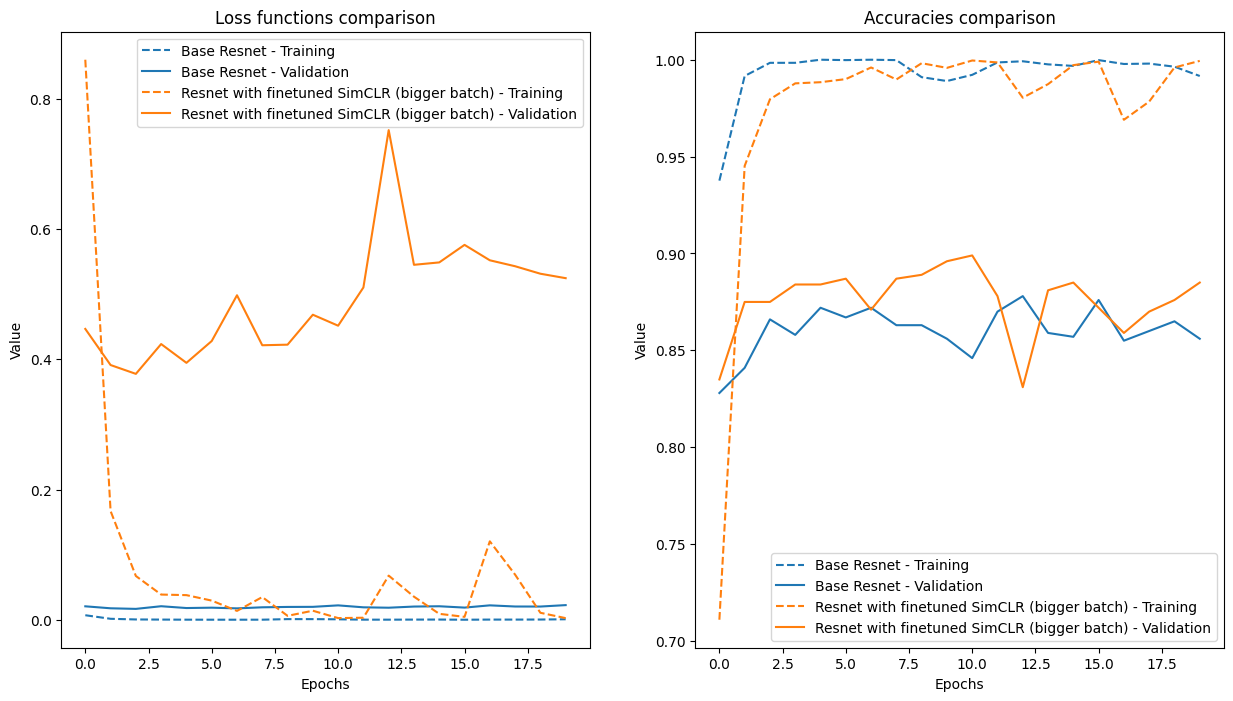

In [ ]:
compare_on_plots(base_resnet_scores, larger_batch_finetuned_simclr_scores)

# Augmentacje na reprezentacjach

In [ ]:
import numpy as np

TRAIN_SIZE = 5000
TEST_SIZE = 1000

indices = np.random.choice(len(train_ds_full), size=TRAIN_SIZE, replace=False)
train_ds = Subset(train_ds_full, indices)

indices = np.random.choice(len(test_ds_full), size=TEST_SIZE, replace=False)
test_ds = Subset(test_ds_full, indices)

train_dl = DataLoader(train_ds, batch_size=128, shuffle=True, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=128, shuffle=False, pin_memory=True)

In [ ]:
simclr_train_ds = FeatureDataset(all_features, all_labels)
simclr_train_loader = torch.utils.data.DataLoader(
    simclr_train_ds, batch_size=128, shuffle=True
)

In [ ]:
model_cifar_10_reps = SimCLRModelFlatWithHiddenAug(temp=0.1, input_dim=512 * 7 * 7)
optimizer = torch.optim.Adam(
    model_cifar_10_reps.parameters(), lr=1e-4, weight_decay=1e-4
)
avg_losses = train_simclr(
    model_cifar_10_reps, simclr_train_loader, optimizer, epochs=50
)
avg_losses

[Epoch 1] [Batch 0] Loss: 3.9574
[Epoch 1] [Batch 10] Loss: 0.8001
[Epoch 1] [Batch 20] Loss: 0.3419
[Epoch 1] [Batch 30] Loss: 0.2100
[Epoch 1] Average Loss: 0.8780
[Epoch 2] [Batch 0] Loss: 0.1753
[Epoch 2] [Batch 10] Loss: 0.1124
[Epoch 2] [Batch 20] Loss: 0.1092
[Epoch 2] [Batch 30] Loss: 0.1004
[Epoch 2] Average Loss: 0.1046
[Epoch 3] [Batch 0] Loss: 0.0928
[Epoch 3] [Batch 10] Loss: 0.0829
[Epoch 3] [Batch 20] Loss: 0.0630
[Epoch 3] [Batch 30] Loss: 0.0715
[Epoch 3] Average Loss: 0.0724
[Epoch 4] [Batch 0] Loss: 0.0558
[Epoch 4] [Batch 10] Loss: 0.0571
[Epoch 4] [Batch 20] Loss: 0.0552
[Epoch 4] [Batch 30] Loss: 0.0535
[Epoch 4] Average Loss: 0.0543
[Epoch 5] [Batch 0] Loss: 0.0508
[Epoch 5] [Batch 10] Loss: 0.0552
[Epoch 5] [Batch 20] Loss: 0.0474
[Epoch 5] [Batch 30] Loss: 0.0495
[Epoch 5] Average Loss: 0.0475
[Epoch 6] [Batch 0] Loss: 0.0478
[Epoch 6] [Batch 10] Loss: 0.0431
[Epoch 6] [Batch 20] Loss: 0.0459
[Epoch 6] [Batch 30] Loss: 0.0400
[Epoch 6] Average Loss: 0.0430
[Epo

[0.8779885087860748,
 0.10460584969259798,
 0.07244088816223666,
 0.05433960864902474,
 0.04751729349663947,
 0.043012469925452025,
 0.04139770874753594,
 0.039426212472608316,
 0.03639891161583364,
 0.03532260517822579,
 0.03262165910564363,
 0.0331110424536746,
 0.03212206193129532,
 0.030767049139831214,
 0.029745413712225853,
 0.029681170493131504,
 0.02872151671908796,
 0.028472811507526785,
 0.02824574992991984,
 0.028283642872702332,
 0.027042876731138678,
 0.026728739732061513,
 0.026517058751778677,
 0.025959082753979602,
 0.026351670897565783,
 0.02576117670396343,
 0.025399826146895066,
 0.025409318064339458,
 0.025272060101269745,
 0.024535793357063084,
 0.024864401202648878,
 0.02472982871113345,
 0.024424616183387114,
 0.024428943649400025,
 0.024236049997853115,
 0.02412391733378172,
 0.023543466594128405,
 0.02379312822886277,
 0.023781547424732707,
 0.02328093776595779,
 0.023174814286176116,
 0.02296127360314131,
 0.022931473416974768,
 0.023031597147928552,
 0.023080

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


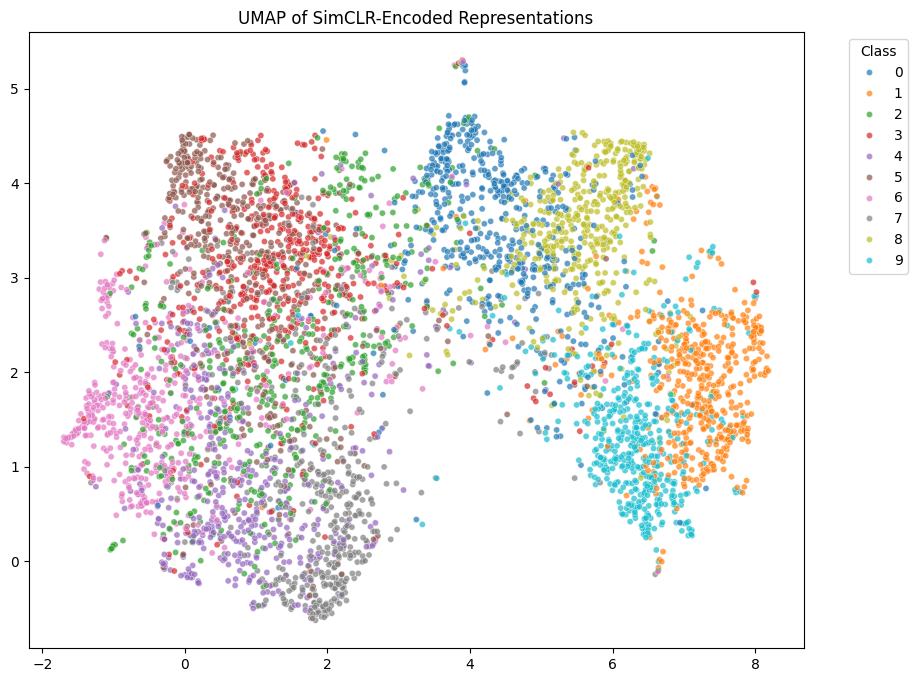

In [ ]:
simclr_features = get_simclr_representations(
    model_cifar_10_reps.encoder, all_features, device=device
)
plot_umap(
    simclr_features, all_labels.numpy(), title="UMAP of SimCLR-Encoded Representations"
)

In [ ]:
import copy

simclr_encoder_frozen = copy.deepcopy(model_cifar_10_reps.encoder).to(device).eval()
simclr_encoder_finetune = copy.deepcopy(model_cifar_10_reps.encoder).to(device)

In [ ]:
print("===== Frozen SimCLR Encoder =====")
frozen_model, train_losses, val_losses, train_accuracies, val_accuracies = (
    run_experiment(
        simclr_encoder_frozen, freeze_simclr=True, epochs=10, return_with_metrics=True
    )
)
train_losses, val_losses, train_accuracies, val_accuracies

===== Frozen SimCLR Encoder =====
Epoch 1/10


Train Loss: 1.4718 | Train Acc: 0.5762
Test Loss:  0.9070 | Test Acc:  0.7600

Epoch 2/10


Train Loss: 0.6481 | Train Acc: 0.8540
Test Loss:  0.5861 | Test Acc:  0.8520

Epoch 3/10


Train Loss: 0.3136 | Train Acc: 0.9458
Test Loss:  0.4945 | Test Acc:  0.8620

Epoch 4/10


Train Loss: 0.1368 | Train Acc: 0.9898
Test Loss:  0.4333 | Test Acc:  0.8760

Epoch 5/10


Train Loss: 0.0808 | Train Acc: 0.9962
Test Loss:  0.4360 | Test Acc:  0.8570

Epoch 6/10


Train Loss: 0.0492 | Train Acc: 0.9980
Test Loss:  0.4133 | Test Acc:  0.8680

Epoch 7/10


Train Loss: 0.0533 | Train Acc: 0.9934
Test Loss:  0.4482 | Test Acc:  0.8530

Epoch 8/10


Train Loss: 0.0308 | Train Acc: 0.9996
Test Loss:  0.4218 | Test Acc:  0.8610

Epoch 9/10


Train Loss: 0.0296 | Train Acc: 0.9982
Test Loss:  0.4037 | Test Acc:  0.8770

Epoch 10/10


Train Loss: 0.0139 | Train Acc: 0.9998
Test Loss:  0.3916 | Test Acc:  0.8700



([1.4718141960144042,
  0.6480944464683532,
  0.3135728294610977,
  0.13675011439323426,
  0.08075821719169617,
  0.04923946146965027,
  0.053259373569488525,
  0.03078484320640564,
  0.029635948932170867,
  0.013927879625558854],
 [0.9070079269409179,
  0.5861498293876648,
  0.49451065135002137,
  0.4332755343914032,
  0.43596649646759034,
  0.41333672642707825,
  0.44823353600502014,
  0.4218088643550873,
  0.4037031548023224,
  0.3915659899711609],
 [0.5762,
  0.854,
  0.9458,
  0.9898,
  0.9962,
  0.998,
  0.9934,
  0.9996,
  0.9982,
  0.9998],
 [0.76, 0.852, 0.862, 0.876, 0.857, 0.868, 0.853, 0.861, 0.877, 0.87])

In [ ]:
hidden_augs_frozen_simclr_scores = {
    "name": "Resnet with frozen SimCLR (hidden augmentations)",
    "train_loss": train_losses[:10],
    "val_loss": val_losses[:10],
    "train_accuracy": train_accuracies[:10],
    "val_accuracy": val_accuracies[:10],
}

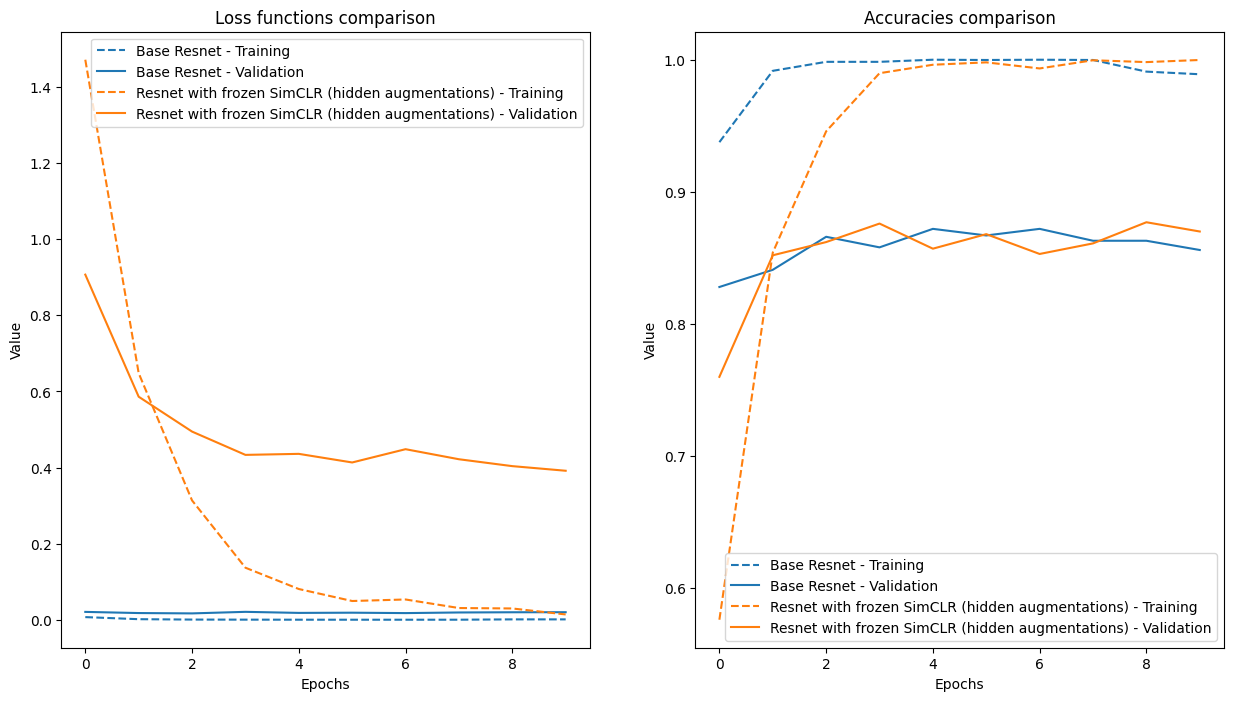

In [ ]:
compare_on_plots(base_resnet_scores, hidden_augs_frozen_simclr_scores)

In [ ]:
print("\n===== Fine-tuned SimCLR Encoder =====")
finetuned_model, train_losses, val_losses, train_accuracies, val_accuracies = (
    run_experiment(
        simclr_encoder_finetune,
        freeze_simclr=False,
        epochs=10,
        return_with_metrics=True,
    )
)


===== Fine-tuned SimCLR Encoder =====


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10


Train Loss: 0.8564 | Train Acc: 0.7168
Test Loss:  0.5172 | Test Acc:  0.8190

Epoch 2/10


Train Loss: 0.1579 | Train Acc: 0.9474
Test Loss:  0.3797 | Test Acc:  0.8790

Epoch 3/10


Train Loss: 0.0310 | Train Acc: 0.9932
Test Loss:  0.4315 | Test Acc:  0.8720

Epoch 4/10


Train Loss: 0.0617 | Train Acc: 0.9786
Test Loss:  0.5547 | Test Acc:  0.8570

Epoch 5/10


Train Loss: 0.0547 | Train Acc: 0.9806
Test Loss:  0.5132 | Test Acc:  0.8720

Epoch 6/10


Train Loss: 0.0189 | Train Acc: 0.9954
Test Loss:  0.5369 | Test Acc:  0.8720

Epoch 7/10


Train Loss: 0.0044 | Train Acc: 0.9992
Test Loss:  0.5505 | Test Acc:  0.8710

Epoch 8/10


Train Loss: 0.1333 | Train Acc: 0.9626
Test Loss:  0.6214 | Test Acc:  0.8420

Epoch 9/10


Train Loss: 0.0633 | Train Acc: 0.9820
Test Loss:  0.5531 | Test Acc:  0.8630

Epoch 10/10


Train Loss: 0.0977 | Train Acc: 0.9726
Test Loss:  0.6153 | Test Acc:  0.8610



In [ ]:
base_resnet_scores = {
    "name": "Base Resnet",
    "train_loss": resnet_results[0][:12],
    "val_loss": resnet_results[1][:12],
    "train_accuracy": resnet_results[2][:12],
    "val_accuracy": resnet_results[3][:12],
}
hidden_augs_finetuned_simclr_scores = {
    "name": "Resnet with finetuned SimCLR (hidden augmentations)",
    "train_loss": train_losses[:12],
    "val_loss": val_losses[:12],
    "train_accuracy": train_accuracies[:12],
    "val_accuracy": val_accuracies[:12],
}

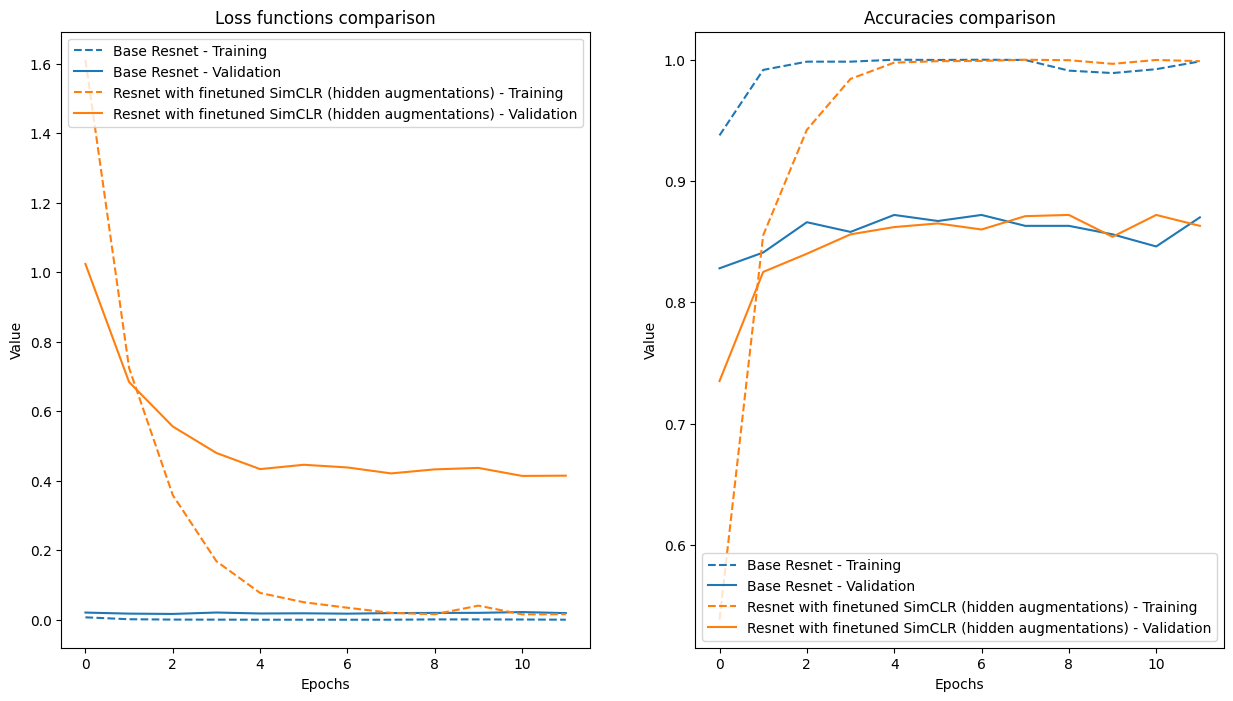

In [ ]:
compare_on_plots(base_resnet_scores, hidden_augs_finetuned_simclr_scores)

# Ortogonalność

In [ ]:
class OrthogonalSimCLRModelFlat(nn.Module):
    def __init__(self, temp=0.1, input_dim=512 * 7 * 7, projection_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
        )
        self.projector = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, projection_dim),
        )
        self.temp = temp
        self.aug_1 = nn.Identity()
        self.aug_2 = nn.Identity()

    def forward(self, x: Tensor) -> Tuple[Tensor, Tensor]:
        x_i = self.aug_1(x)
        x_j = self.aug_2(x)

        z_i = self.projector(self.encoder(x_i))
        z_j = self.projector(self.encoder(x_j))
        return z_i, z_j

    def forward_repr(self, x: Tensor) -> Tensor:
        return self.encoder(x)

    def info_nce_loss(
        self, z_i: Tensor, z_j: Tensor, lambda_ortho: float = 0.1
    ) -> Tensor:
        z = torch.cat([z_i, z_j], dim=0)
        z = F.normalize(z, dim=1)
        sim = torch.matmul(z, z.T) / self.temp

        batch_size = z_i.size(0)
        N = 2 * batch_size
        identity_mask = ~torch.eye(N, dtype=torch.bool, device=z.device)

        positive_indices = torch.arange(batch_size, device=z.device)
        positives = torch.cat([positive_indices + batch_size, positive_indices])

        numerator = torch.exp(sim[torch.arange(N), positives])
        denominator = torch.sum(torch.exp(sim) * identity_mask, dim=1)
        nce_loss = (-torch.log(numerator / denominator)).mean()

        similarity_matrix = torch.matmul(z_i, z_i.T)
        off_diagonal = similarity_matrix - torch.eye(batch_size, device=z.device)
        ortho_loss = (off_diagonal**2).sum() / batch_size

        return nce_loss + lambda_ortho * ortho_loss

In [ ]:
import numpy as np

TRAIN_SIZE = 5000
TEST_SIZE = 1000

indices = np.random.choice(len(train_ds_full), size=TRAIN_SIZE, replace=False)
train_ds = Subset(train_ds_full, indices)

indices = np.random.choice(len(test_ds_full), size=TEST_SIZE, replace=False)
test_ds = Subset(test_ds_full, indices)

train_dl = DataLoader(train_ds, batch_size=128, shuffle=True, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=128, shuffle=False, pin_memory=True)

In [ ]:
simclr_train_ds = FeatureDataset(all_features, all_labels)
simclr_train_loader = torch.utils.data.DataLoader(
    simclr_train_ds, batch_size=128, shuffle=True
)

In [ ]:
resnet = torchvision.models.resnet18(pretrained=True)
feature_extractor = nn.Sequential(*list(resnet.children())[:-2])

feature_extractor.eval()
all_features = []
all_labels = []

with torch.no_grad():
    for imgs, labels in train_dl:
        feats = feature_extractor(imgs)
        feats = torch.flatten(feats, start_dim=1)
        all_features.append(feats)
        all_labels.append(labels)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 179MB/s]


In [ ]:
all_features = torch.cat(all_features)
all_labels = torch.cat(all_labels)

In [ ]:
simclr_train_ds = FeatureDataset(all_features, all_labels)
simclr_train_loader = torch.utils.data.DataLoader(
    simclr_train_ds, batch_size=64, shuffle=True
)

In [ ]:
model_cifar_10_reps = OrthogonalSimCLRModelFlat(temp=0.1, input_dim=512 * 7 * 7)
optimizer = torch.optim.Adam(
    model_cifar_10_reps.parameters(), lr=1e-4, weight_decay=1e-4
)
train_simclr(model_cifar_10_reps, simclr_train_loader, optimizer, epochs=60)

[Epoch 1] [Batch 0] Loss: 6.8463
[Epoch 1] [Batch 10] Loss: 2.9435
[Epoch 1] [Batch 20] Loss: 0.8869
[Epoch 1] [Batch 30] Loss: 0.4964
[Epoch 1] Average Loss: 2.5966
[Epoch 2] [Batch 0] Loss: 0.3336
[Epoch 2] [Batch 10] Loss: 0.2424
[Epoch 2] [Batch 20] Loss: 0.2171
[Epoch 2] [Batch 30] Loss: 0.2103
[Epoch 2] Average Loss: 0.2334
[Epoch 3] [Batch 0] Loss: 0.1802
[Epoch 3] [Batch 10] Loss: 0.1735
[Epoch 3] [Batch 20] Loss: 0.1704
[Epoch 3] [Batch 30] Loss: 0.1566
[Epoch 3] Average Loss: 0.1663
[Epoch 4] [Batch 0] Loss: 0.1590
[Epoch 4] [Batch 10] Loss: 0.1444
[Epoch 4] [Batch 20] Loss: 0.1569
[Epoch 4] [Batch 30] Loss: 0.1494
[Epoch 4] Average Loss: 0.1488
[Epoch 5] [Batch 0] Loss: 0.1534
[Epoch 5] [Batch 10] Loss: 0.1423
[Epoch 5] [Batch 20] Loss: 0.1380
[Epoch 5] [Batch 30] Loss: 0.1397
[Epoch 5] Average Loss: 0.1402
[Epoch 6] [Batch 0] Loss: 0.1478
[Epoch 6] [Batch 10] Loss: 0.1312
[Epoch 6] [Batch 20] Loss: 0.1501
[Epoch 6] [Batch 30] Loss: 0.1291
[Epoch 6] Average Loss: 0.1354
[Epo

[2.5965951278805735,
 0.23336875550448893,
 0.16634550765156747,
 0.14878986962139606,
 0.14019360039383172,
 0.1353811314329505,
 0.13172493018209935,
 0.12638128958642483,
 0.12450169008225202,
 0.12465755306184292,
 0.12486984692513943,
 0.11823341120034456,
 0.11737241558730602,
 0.11679860111325979,
 0.11690003909170628,
 0.11476658657193184,
 0.11389735136181116,
 0.11188635360449553,
 0.10986317303031683,
 0.11148850424215198,
 0.10874591022729874,
 0.10839237887412309,
 0.10736065050587058,
 0.10672819335013628,
 0.10552268093451858,
 0.10455396510660649,
 0.10316262179985643,
 0.10259452844038605,
 0.1024485882371664,
 0.10095473313704133,
 0.10021524000912904,
 0.09900993928313255,
 0.09853669572621584,
 0.09795340690761804,
 0.09853625688701868,
 0.0977674157358706,
 0.0959196999669075,
 0.09697960754856468,
 0.09528885930776596,
 0.09469205858185888,
 0.09492085529491305,
 0.09401591252535582,
 0.09286512844264508,
 0.09247958799824119,
 0.09170988602563739,
 0.092259546928

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


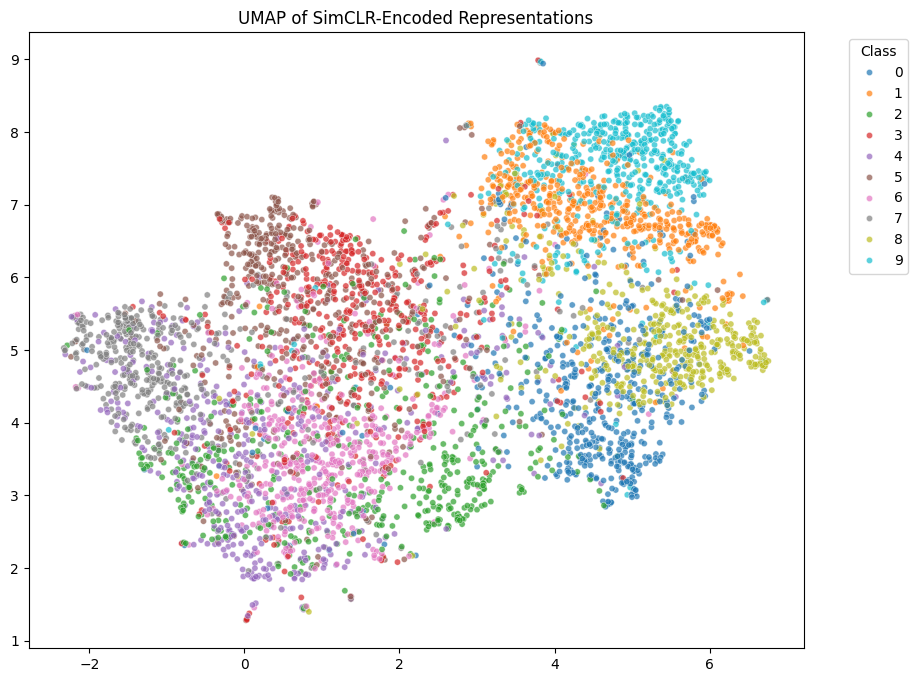

In [ ]:
simclr_features = get_simclr_representations(
    model_cifar_10_reps.encoder, all_features, device=device
)
plot_umap(
    simclr_features, all_labels.numpy(), title="UMAP of SimCLR-Encoded Representations"
)

In [ ]:
import copy

simclr_encoder_frozen = copy.deepcopy(model_cifar_10_reps.encoder).to(device).eval()
simclr_encoder_finetune = copy.deepcopy(model_cifar_10_reps.encoder).to(device)

In [ ]:
print("===== Frozen SimCLR Encoder =====")
frozen_model, train_losses, val_losses, train_accuracies, val_accuracies = (
    run_experiment(
        simclr_encoder_frozen, freeze_simclr=True, epochs=10, return_with_metrics=True
    )
)
train_losses, val_losses, train_accuracies, val_accuracies

===== Frozen SimCLR Encoder =====


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10


Train Loss: 1.7774 | Train Acc: 0.4856
Test Loss:  1.2193 | Test Acc:  0.6550

Epoch 2/10


Train Loss: 0.9735 | Train Acc: 0.8064
Test Loss:  0.8349 | Test Acc:  0.8090

Epoch 3/10


Train Loss: 0.5504 | Train Acc: 0.9160
Test Loss:  0.6487 | Test Acc:  0.8410

Epoch 4/10


Train Loss: 0.3066 | Train Acc: 0.9676
Test Loss:  0.5188 | Test Acc:  0.8650

Epoch 5/10


Train Loss: 0.1478 | Train Acc: 0.9942
Test Loss:  0.4655 | Test Acc:  0.8590

Epoch 6/10


Train Loss: 0.0785 | Train Acc: 0.9990
Test Loss:  0.4269 | Test Acc:  0.8730

Epoch 7/10


Train Loss: 0.0545 | Train Acc: 0.9990
Test Loss:  0.4273 | Test Acc:  0.8660

Epoch 8/10


Train Loss: 0.0353 | Train Acc: 0.9996
Test Loss:  0.4211 | Test Acc:  0.8660

Epoch 9/10


Train Loss: 0.0555 | Train Acc: 0.9944
Test Loss:  0.4322 | Test Acc:  0.8660

Epoch 10/10


Train Loss: 0.0456 | Train Acc: 0.9958
Test Loss:  0.4051 | Test Acc:  0.8710



([1.777428877067566,
  0.9734758178710937,
  0.550373985004425,
  0.30662761328220367,
  0.14778634548187256,
  0.07851665849685668,
  0.05450732581615448,
  0.035301114511489866,
  0.055530392932891845,
  0.045594935691356656],
 [1.2193041534423827,
  0.8348604612350464,
  0.648687219619751,
  0.5187842350006103,
  0.4655173053741455,
  0.42685648703575135,
  0.4272739613056183,
  0.42112618684768677,
  0.43223873209953306,
  0.4051057002544403],
 [0.4856, 0.8064, 0.916, 0.9676, 0.9942, 0.999, 0.999, 0.9996, 0.9944, 0.9958],
 [0.655, 0.809, 0.841, 0.865, 0.859, 0.873, 0.866, 0.866, 0.866, 0.871])

In [ ]:
base_resnet_scores = {
    "name": "Base Resnet",
    "train_loss": resnet_results[0][:10],
    "val_loss": resnet_results[1][:10],
    "train_accuracy": resnet_results[2][:10],
    "val_accuracy": resnet_results[3][:10],
}
frozen_simclr_scores_ortogonal = {
    "name": "Resnet with frozen SimCLR (with ortogonality)",
    "train_loss": train_losses,
    "val_loss": val_losses,
    "train_accuracy": train_accuracies,
    "val_accuracy": val_accuracies,
}

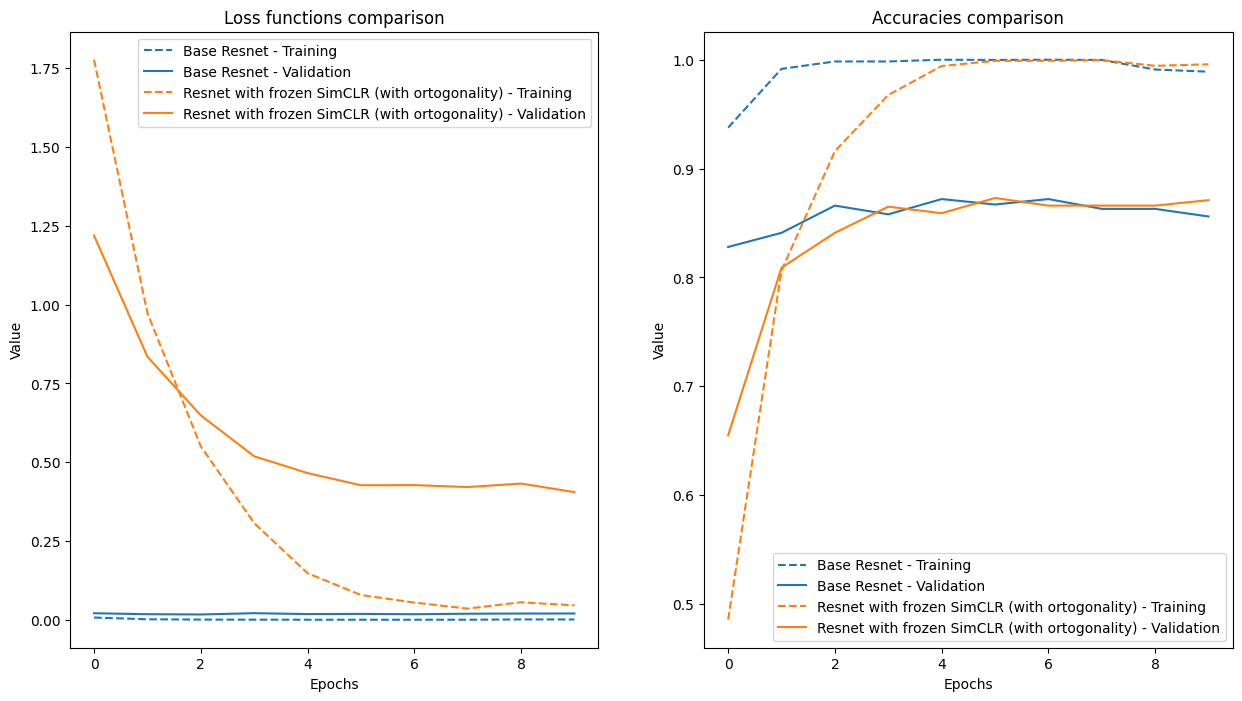

In [ ]:
compare_on_plots(base_resnet_scores, frozen_simclr_scores_ortogonal)

In [ ]:
print("\n===== Fine-tuned SimCLR Encoder =====")
finetuned_model, train_losses, val_losses, train_accuracies, val_accuracies = (
    run_experiment(
        simclr_encoder_finetune,
        freeze_simclr=False,
        epochs=10,
        return_with_metrics=True,
        lr=5e-5,
    )
)
train_losses, val_losses, train_accuracies, val_accuracies


===== Fine-tuned SimCLR Encoder =====


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10


Train Loss: 1.2819 | Train Acc: 0.6166
Test Loss:  0.5672 | Test Acc:  0.8150

Epoch 2/10


Train Loss: 0.3416 | Train Acc: 0.8896
Test Loss:  0.3796 | Test Acc:  0.8750

Epoch 3/10


Train Loss: 0.1095 | Train Acc: 0.9746
Test Loss:  0.3817 | Test Acc:  0.8670

Epoch 4/10


Train Loss: 0.0309 | Train Acc: 0.9976
Test Loss:  0.3591 | Test Acc:  0.8860

Epoch 5/10


Train Loss: 0.0138 | Train Acc: 0.9994
Test Loss:  0.3883 | Test Acc:  0.8820

Epoch 6/10


Train Loss: 0.0417 | Train Acc: 0.9908
Test Loss:  0.3995 | Test Acc:  0.8840

Epoch 7/10


Train Loss: 0.0072 | Train Acc: 0.9994
Test Loss:  0.3786 | Test Acc:  0.8880

Epoch 8/10


Train Loss: 0.0268 | Train Acc: 0.9942
Test Loss:  0.4473 | Test Acc:  0.8810

Epoch 9/10


Train Loss: 0.0044 | Train Acc: 0.9998
Test Loss:  0.4076 | Test Acc:  0.8870

Epoch 10/10


Train Loss: 0.0106 | Train Acc: 0.9986
Test Loss:  0.4282 | Test Acc:  0.8950



([1.2819072099685669,
  0.34161114995479586,
  0.10951973650455475,
  0.030932289600372316,
  0.013780780375003814,
  0.04172696014419198,
  0.007241873753070832,
  0.02675509445518255,
  0.004409350404143334,
  0.010644807487726211],
 [0.5671983995437622,
  0.3796252789497375,
  0.3816549906730652,
  0.35906063961982726,
  0.38833288884162903,
  0.39947652077674867,
  0.3786100654602051,
  0.44728999185562135,
  0.40756356048583986,
  0.4282226457595825],
 [0.6166,
  0.8896,
  0.9746,
  0.9976,
  0.9994,
  0.9908,
  0.9994,
  0.9942,
  0.9998,
  0.9986],
 [0.815, 0.875, 0.867, 0.886, 0.882, 0.884, 0.888, 0.881, 0.887, 0.895])

In [ ]:
base_resnet_scores = {
    "name": "Base Resnet",
    "train_loss": resnet_results[0][:10],
    "val_loss": resnet_results[1][:10],
    "train_accuracy": resnet_results[2][:10],
    "val_accuracy": resnet_results[3][:10],
}
orogonal_finetuned_simclr_scores = {
    "name": "Resnet with finetuned SimCLR (with ortogonality)",
    "train_loss": train_losses,
    "val_loss": val_losses,
    "train_accuracy": train_accuracies,
    "val_accuracy": val_accuracies,
}

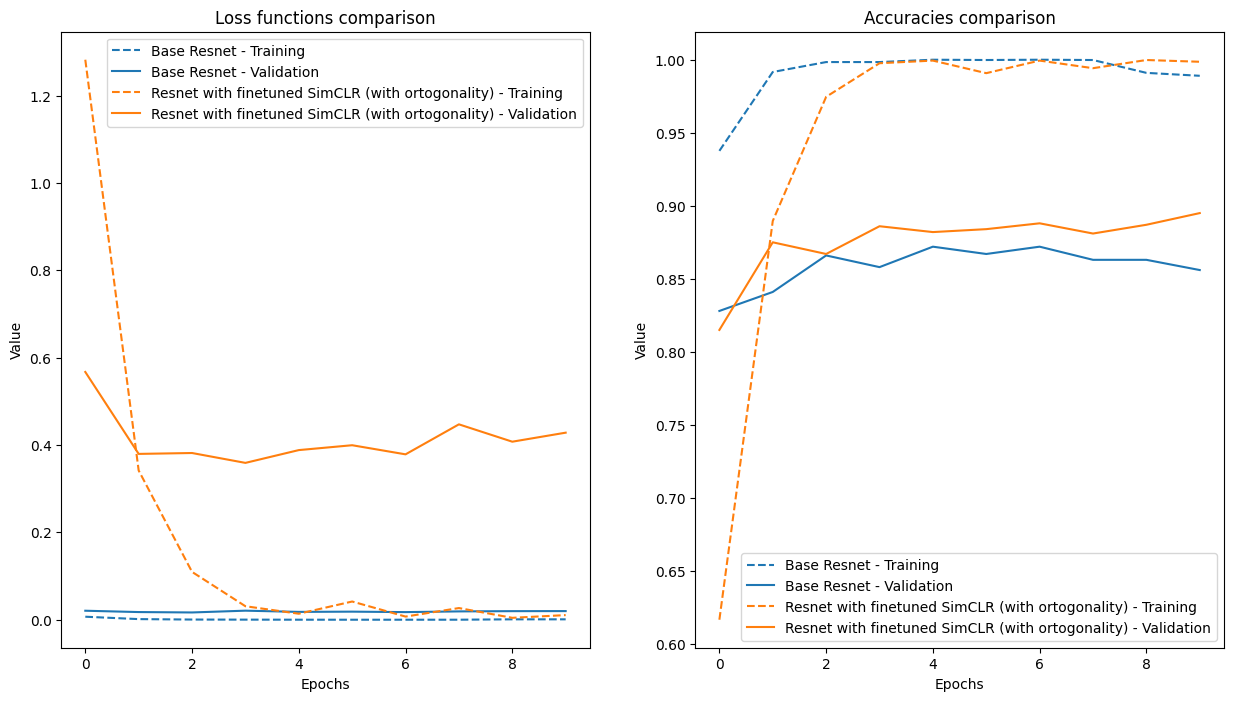

In [ ]:
compare_on_plots(base_resnet_scores, orogonal_finetuned_simclr_scores)